# ETF Asset Allocation Model

## Contents

- ### Introduction（1）
- ### DataSet, Investment Universe and Data Processing（2）
- ### Portfolio Construction and Backtest（3）

# 1. Introduction（investment ideas）

### Methodology
基於投資組合分散的目的，投資於股票型、債券型及黃金ETF。

**權重配置**
- 0050：0.5。
- 00679B：0.25。
- 00635U：0.25。
- 由於00679B的上市期間晚於0050，故在上市前的部位會以0050取代；00635U的上市期間晚於0050及00679B，故在上市前的部位會以0050及00679B取代。

**再平衡**
- 月初。

**滑價**
- 使用預設模型。

### Reference
Trading Evolved: Anyone can Build Killer Trading Strategies in Python pp. 135-154

# 2. DataSet and Investment Universe

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pandas as pd
import tejapi
import empyrical as ep
from logbook import Logger, StderrHandler, INFO

tej_key = 'your key'
api_base = 'https://api.tej.com.tw'

os.environ['TEJAPI_KEY'] = tej_key
os.environ['TEJAPI_BASE']= api_base

tejapi.ApiConfig.api_key = tej_key  
tejapi.ApiConfig.api_base = api_base

# calendar
calendar_name='TEJ'

# bundle_name
bundle_name = 'tquant'

# set date
start='2005-01-01'
end='2023-08-25'


# 由文字型態轉為Timestamp，供回測使用
tz = 'UTC'
start_dt, end_dt = pd.Timestamp(start, tz = tz), pd.Timestamp(end, tz = tz)

# 設定os.environ['mdate'] = start+' '+end，供ingest bundle使用
os.environ['mdate'] = start+' '+end

pd.set_option('display.max_rows', 80)

# 設定log顯示方式
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

In [3]:
# 取得start當天所有ETF的公司碼
attr = tejapi.get('TWN/APISTKATTR',
                  stktp_e='ETF',
                  mdate={'gte':start,'lte':end},
                  opts={'columns':['coid','mdate','stktp_e']},
                  paginate=True)

In [4]:
attr.drop_duplicates(subset=['coid'], keep='last')

,coid,mdate,stktp_e
None,,,
96,0001,2005-05-30 00:00:00+00:00,ETF
2360,0015,2014-02-18 00:00:00+00:00,ETF
2460,0029,2005-06-02 00:00:00+00:00,ETF
7054,0050,2023-08-25 00:00:00+00:00,ETF
11238,0051,2023-08-25 00:00:00+00:00,ETF
...,...,...,...
386064,01008T,2015-04-07 00:00:00+00:00,ETF
387329,01009T,2023-08-25 00:00:00+00:00,ETF
388477,01010T,2023-08-25 00:00:00+00:00,ETF


In [5]:
# 設定os.environ['ticker']=公司碼，供後續ingest bundle用。

os.environ['ticker'] = ' '.join(list(set(attr.coid))+['IR0001'])

In [6]:
os.environ['ticker']

'00655L 00739 0015 00783 00698L 00741B 00886 00917 00777B 00846B 00896 00860B 0050 00779B 00890B 00753L 00895 00905 00767 00839B 00637L 00679B 00669R 00751B 01003T 00774C 00908 00883B 00646 00663L 00754B 00729R 00702 00659R 00761B 00794B 00781B 00742 00875 00911 00887 00930 00731 00676R 00689R 00858 006207 00849B 00919 00652 006202 00699R 0053 00748B 00852L 00744B 00870B 00891 00730 00766L 00672L 00833B 00786B 00727B 00844B 00782B 00685L 00775B 006205 00901 00634R 00848B 00724B 00737 T1010Y 00925 00743 00740B 00842B 00733 0059 00830 00718B 006206 00656R 00636K 00910 00770 00904 00771 00691R 00728 00788B 00638R 00687B 00725B 00696B 00706L 00861 00658L 00720B 00705R 00635U 00900 00774B 00674R 0055 00795B 00915 00677U 00631L 0029 00850 T1001Y 00760B 00654R 00854B 00768B 00922 00657 00838B 00668 00713 00645 00682U 00912 00880B 00882 00747B 00765B 00841B 00894 006208 00923 00758B 00701 00703 00865B 00639 00792B 00853B 00712 00869B 00835B 00704L 00784B 00678 00666R 00643K 00903 00837B 00799B

## Ingest

In [7]:
!zipline ingest -b tquant

Merging daily equity files:


[2023-08-31 03:47:11.008901] INFO: zipline.data.bundles.core: Ingesting tquant.


## Investment Universe

In [8]:
# set universe and weight
securities = {
                '0050': 0.5,     # 市值型：元大台灣卓越50證券投資信託基金（臺灣50指數 FTSE TWSE Taiwan 50 Index）
                '00679B': 0.25,  # 債券型：元大美國政府20年期(以上)債券證券投資信託基金（ICE美國政府20+年期債券指數 (ICE U.S.Treasury 20+ Year Bond Index）
                '00635U': 0.25   # 期貨型：元大標普高盛黃金ER指數股票型期貨信託基金（標普高盛黃金超額回報指數 S&P GSCI Gold Excess Return Index）
            }

# 3. Portfolio Construction and Backtest

[2023-08-31 03:47:56.605544]: INFO: rebalance: 2005-01-03 can trade sec:['0050']
[2023-08-31 03:47:56.633651]: INFO: rebalance: 2005-02-01 can trade sec:['0050']
[2023-08-31 03:47:56.649652]: INFO: rebalance: 2005-03-01 can trade sec:['0050']
[2023-08-31 03:47:56.678427]: INFO: rebalance: 2005-04-01 can trade sec:['0050']
[2023-08-31 03:47:56.702430]: INFO: rebalance: 2005-05-03 can trade sec:['0050']
[2023-08-31 03:47:56.717893]: INFO: earn_dividends: Equity(1 [0050]), cash_dividend amount: 1.85, pay_date: 2005-06-13, div_owed: 389347.30000000005
[2023-08-31 03:47:56.730894]: INFO: rebalance: 2005-06-01 can trade sec:['0050']
[2023-08-31 03:47:56.757915]: INFO: rebalance: 2005-07-01 can trade sec:['0050']
[2023-08-31 03:47:56.783800]: INFO: rebalance: 2005-08-01 can trade sec:['0050']
[2023-08-31 03:47:56.810493]: INFO: rebalance: 2005-09-02 can trade sec:['0050']
[2023-08-31 03:47:56.837327]: INFO: rebalance: 2005-10-03 can trade sec:['0050']
[2023-08-31 03:47:56.861295]: INFO: rebal

[2023-08-31 03:47:58.936648]: INFO: rebalance: 2012-06-01 can trade sec:['0050']
[2023-08-31 03:47:58.963795]: INFO: rebalance: 2012-07-02 can trade sec:['0050']
[2023-08-31 03:47:58.992328]: INFO: rebalance: 2012-08-01 can trade sec:['0050']
[2023-08-31 03:47:59.020328]: INFO: rebalance: 2012-09-03 can trade sec:['0050']
[2023-08-31 03:47:59.045500]: INFO: rebalance: 2012-10-01 can trade sec:['0050']
[2023-08-31 03:47:59.061303]: INFO: earn_dividends: Equity(1 [0050]), cash_dividend amount: 1.85, pay_date: 2012-11-27, div_owed: 523481.55000000005
[2023-08-31 03:47:59.067877]: INFO: rebalance: 2012-11-01 can trade sec:['0050']
[2023-08-31 03:47:59.100932]: INFO: rebalance: 2012-12-03 can trade sec:['0050']
[2023-08-31 03:47:59.127823]: INFO: rebalance: 2013-01-02 can trade sec:['0050']
[2023-08-31 03:47:59.149084]: INFO: rebalance: 2013-02-01 can trade sec:['0050']
[2023-08-31 03:47:59.172666]: INFO: rebalance: 2013-03-01 can trade sec:['0050']
[2023-08-31 03:47:59.200044]: INFO: rebal

[2023-08-31 03:48:01.778263]: INFO: earn_dividends: Equity(1 [0050]), cash_dividend amount: 0.7, pay_date: 2018-08-27, div_owed: 107688.0
[2023-08-31 03:48:01.813277]: INFO: rebalance: 2018-08-01 can trade sec:['0050', '00679B', '00635U']
[2023-08-31 03:48:01.853280]: INFO: earn_dividends: Equity(73 [00679B]), cash_dividend amount: 0.27, pay_date: 2018-09-26, div_owed: 45549.270000000004
[2023-08-31 03:48:01.861245]: INFO: rebalance: 2018-09-03 can trade sec:['0050', '00679B', '00635U']
[2023-08-31 03:48:01.925729]: INFO: rebalance: 2018-10-01 can trade sec:['0050', '00679B', '00635U']
[2023-08-31 03:48:01.983770]: INFO: rebalance: 2018-11-01 can trade sec:['0050', '00679B', '00635U']
[2023-08-31 03:48:02.019718]: INFO: earn_dividends: Equity(73 [00679B]), cash_dividend amount: 0.245, pay_date: 2018-12-25, div_owed: 40930.19
[2023-08-31 03:48:02.043412]: INFO: rebalance: 2018-12-03 can trade sec:['0050', '00679B', '00635U']
[2023-08-31 03:48:02.115762]: INFO: rebalance: 2019-01-02 can 

[2023-08-31 03:48:04.392654]: INFO: rebalance: 2022-07-01 can trade sec:['0050', '00679B', '00635U']
[2023-08-31 03:48:04.424651]: INFO: earn_dividends: Equity(1 [0050]), cash_dividend amount: 1.8, pay_date: 2022-08-19, div_owed: 274604.4
[2023-08-31 03:48:04.451654]: INFO: rebalance: 2022-08-01 can trade sec:['0050', '00679B', '00635U']
[2023-08-31 03:48:04.483651]: INFO: earn_dividends: Equity(73 [00679B]), cash_dividend amount: 0.29, pay_date: 2022-09-12, div_owed: 71435.7
[2023-08-31 03:48:04.515045]: INFO: rebalance: 2022-09-01 can trade sec:['0050', '00679B', '00635U']
[2023-08-31 03:48:04.573193]: INFO: rebalance: 2022-10-03 can trade sec:['0050', '00679B', '00635U']
[2023-08-31 03:48:04.628195]: INFO: rebalance: 2022-11-01 can trade sec:['0050', '00679B', '00635U']
[2023-08-31 03:48:04.659906]: INFO: earn_dividends: Equity(73 [00679B]), cash_dividend amount: 0.33, pay_date: 2022-12-12, div_owed: 81746.28
[2023-08-31 03:48:04.677370]: INFO: rebalance: 2022-12-01 can trade sec:['

Ready to analyze result.


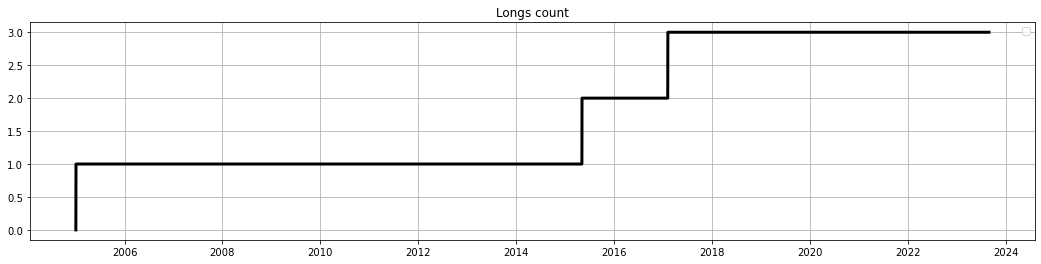

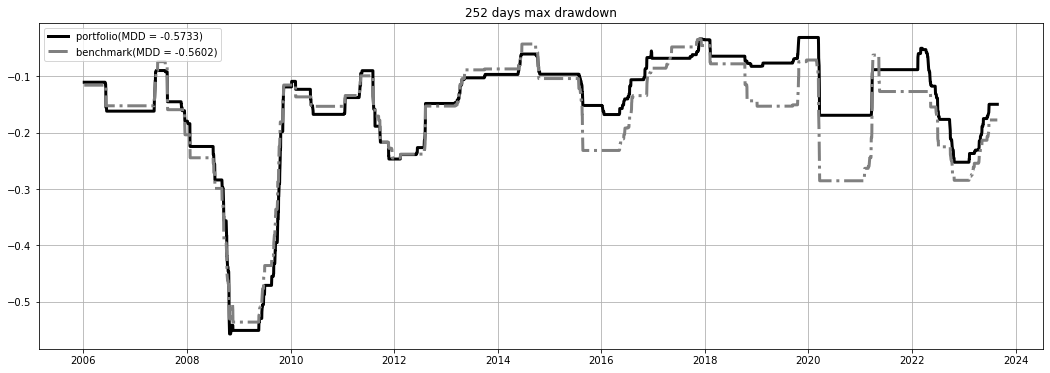

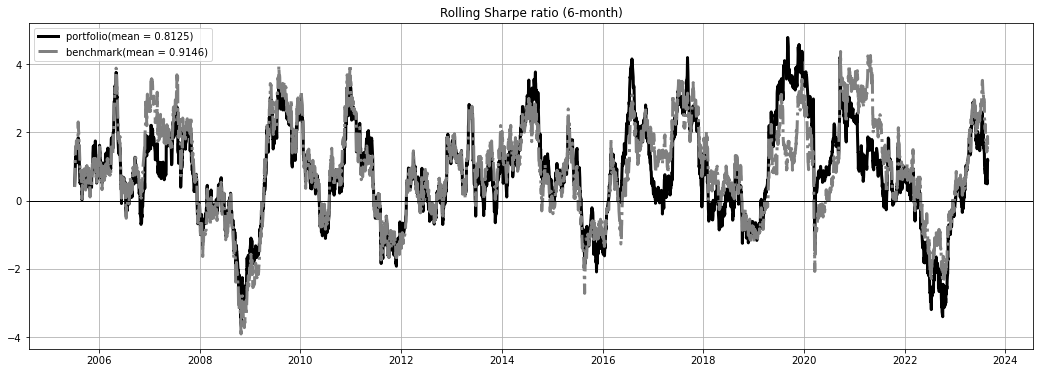

In [9]:
%matplotlib inline

import zipline
from zipline import run_algorithm
from zipline.api import (order_target_percent,
                         symbol,
                         schedule_function,
                         date_rules,
                         time_rules,
                         set_benchmark,
                         get_datetime)
from zipline.utils.calendar_utils import get_calendar 

from pandas import Timestamp
from matplotlib import pyplot as plt
import pandas as pd
from logbook import Logger, StderrHandler, INFO


def initialize(context):
    # Securities and target weights
    context.securities = securities   
    set_benchmark(symbol('IR0001'))
        
    # Schedule rebalance for once a month
    schedule_function(rebalance,
                      date_rules.month_start(),
                      time_rules.market_open())
    
def rebalance(context, data):
    
    can_trade_sec = []
    
#     Loop through the securities    
    for sec, weight in context.securities.items():
        try:
            sym = symbol(sec)
            # Check if we can trade
            if data.can_trade(sym):
                # construct a can trade list
                can_trade_sec.append(sec)
        except:
            log.info(str(sym) + ' does not exist on bundle: ' + get_datetime().strftime('%Y-%m-%d'))
        
    total_weight = sum(value for key, value in context.securities.items() if key in can_trade_sec)

    if len(can_trade_sec)>0:
        log.info(get_datetime().strftime('%Y-%m-%d') + ' can trade sec:' + str(can_trade_sec))
    
#     Start trading
    for sec in can_trade_sec:
        sym = symbol(sec)
        weight = context.securities[sec]
        # Reset the weight
        order_target_percent(sym, weight * ((1-total_weight) * 1 / total_weight + 1))    
            
def analyze(context, perf):
    
#     longs_count
    fig, ax = plt.subplots(figsize=(18, 4))
    
    ax.plot(perf['longs_count'], 
            linestyle='-', 
            color='black',
            linewidth=3.0)

    ax.set_title(label='Longs count')
    ax.legend()
    ax.grid(True)
        
#     MDD
    fig, ax = plt.subplots(figsize=(18, 6))
 
    window = 252
 
    mdd = ep.stats.roll_max_drawdown(perf['returns'],
                                     window=window)
    mdd_x = mdd.sort_index().round(10).idxmin()
    mdd_y = mdd.min()

    ax.plot(mdd, 
        label='portfolio(MDD = {})'.format(round(ep.max_drawdown(perf['returns']),4)), 
        linestyle='-', 
        color='black',
        linewidth=3.0)
    
   
    benchmark_mdd = ep.stats.roll_max_drawdown(perf['benchmark_return'],
                                               window=window)
    benchmark_mdd_x = benchmark_mdd.sort_index().round(10).idxmin()
    benchmark_mdd_y = benchmark_mdd.min()

    ax.plot(benchmark_mdd, 
        label='benchmark(MDD = {})'.format(round(ep.max_drawdown(perf['benchmark_return']),4)), 
        linestyle='-.', 
        color='gray',
        linewidth=3.0)
        
    ax.set_title(label='{} days max drawdown'.format(window))
    ax.legend()
    ax.grid(True)
    
#     roll_sharpe_ratio
    fig, ax = plt.subplots(figsize=(18, 6))
    
    rolling_sharpe = ep.stats.roll_sharpe_ratio(perf['returns'],
                                                window=21 * 6)
    
    portfolio_mean_sharpe_ratio = rolling_sharpe.mean()
    
    
    benchmark_rolling_sharpe = ep.stats.roll_sharpe_ratio(perf['benchmark_return'],
                                                          window=21 * 6)
    
    benchmark_mean_sharpe_ratio = benchmark_rolling_sharpe.mean()
    
    ax.plot(rolling_sharpe, 
            label='portfolio(mean = {})'.format(round(portfolio_mean_sharpe_ratio,4)), 
            linestyle='-', 
            color='black',
            linewidth=3.0)
    
    ax.plot(benchmark_rolling_sharpe, 
        label='benchmark(mean = {})'.format(round(benchmark_mean_sharpe_ratio,4)), 
        linestyle='-.', 
        color='gray',
        linewidth=3.0)

    ax.axhline(0.0, color="black", linestyle="-", lw=1)
    
    ax.set_title(label='Rolling Sharpe ratio (6-month)')
    ax.legend()
    ax.grid(True)

# Fire off backtest
result = run_algorithm(start=start_dt,            
                       end=end_dt,                          
                       initialize=initialize,
                       analyze=analyze,
                       capital_base=1e7,
                       data_frequency='daily',
                       bundle=bundle_name,
                       trading_calendar=get_calendar(calendar_name))

print("Ready to analyze result.")

## Pyfolio

In [10]:
import pyfolio as pf
from pyfolio.utils import extract_rets_pos_txn_from_zipline
from pyfolio.txn import make_transaction_frame
import empyrical

In [11]:
# Extract returns, positions, transactions and leverage from the backtest data structure returned by zipline.
# TradingAlgorithm.run().
returns, positions, transactions = extract_rets_pos_txn_from_zipline(result)

In [12]:
benchmark_rets = result['benchmark_return']

In [13]:
# The data must have a **tz-aware DateTimeIndex set to UTC**, with a time of **0:00**, 
# otherwise some plots won't be able to be generated.
returns.index = returns.index.tz_localize(None).tz_localize('UTC')
positions.index = positions.index.tz_localize(None).tz_localize('UTC')
transactions.index = transactions.index.tz_localize(None).tz_localize('UTC')
benchmark_rets.index = benchmark_rets.index.tz_localize(None).tz_localize('UTC')

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,57.33,2007-10-11,2008-11-20,2011-01-19,822
1,25.27,2022-01-17,2022-10-25,NaT,NaN
2,24.70,2011-01-28,2011-11-25,2013-05-16,565
3,16.95,2020-03-09,2020-03-19,2020-06-10,65
4,16.82,2015-04-27,2016-01-20,2016-07-11,297


Stress Events,mean,min,max
Lehman,-0.29%,-4.75%,6.99%
US downgrade/European Debt Crisis,-0.33%,-5.88%,3.50%
Fukushima,0.18%,-1.72%,2.17%
EZB IR Event,0.13%,-0.82%,2.49%
Aug07,-0.02%,-4.52%,4.53%
Mar08,-0.04%,-2.93%,4.22%
Sept08,-0.69%,-4.75%,6.99%
2009Q1,0.03%,-6.35%,3.81%
2009Q2,0.61%,-3.92%,7.00%
Flash Crash,-0.97%,-2.75%,0.87%


Top 10 long positions of all time,max
sid,
0050,100.05%
00635U,37.81%
00679B,28.27%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
0050,100.05%
00635U,37.81%
00679B,28.27%


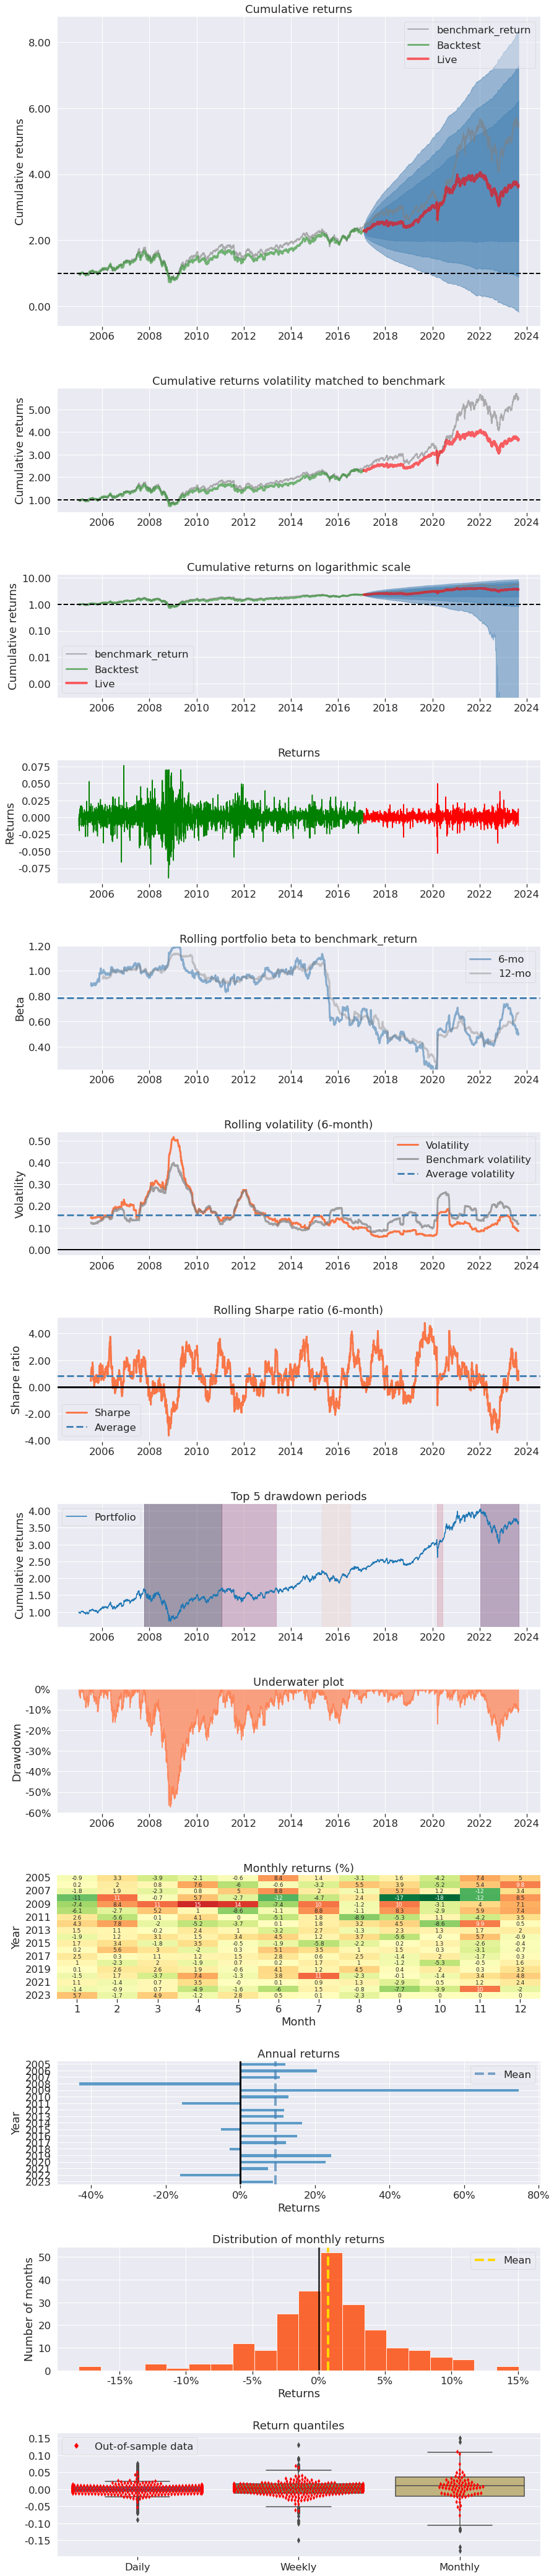

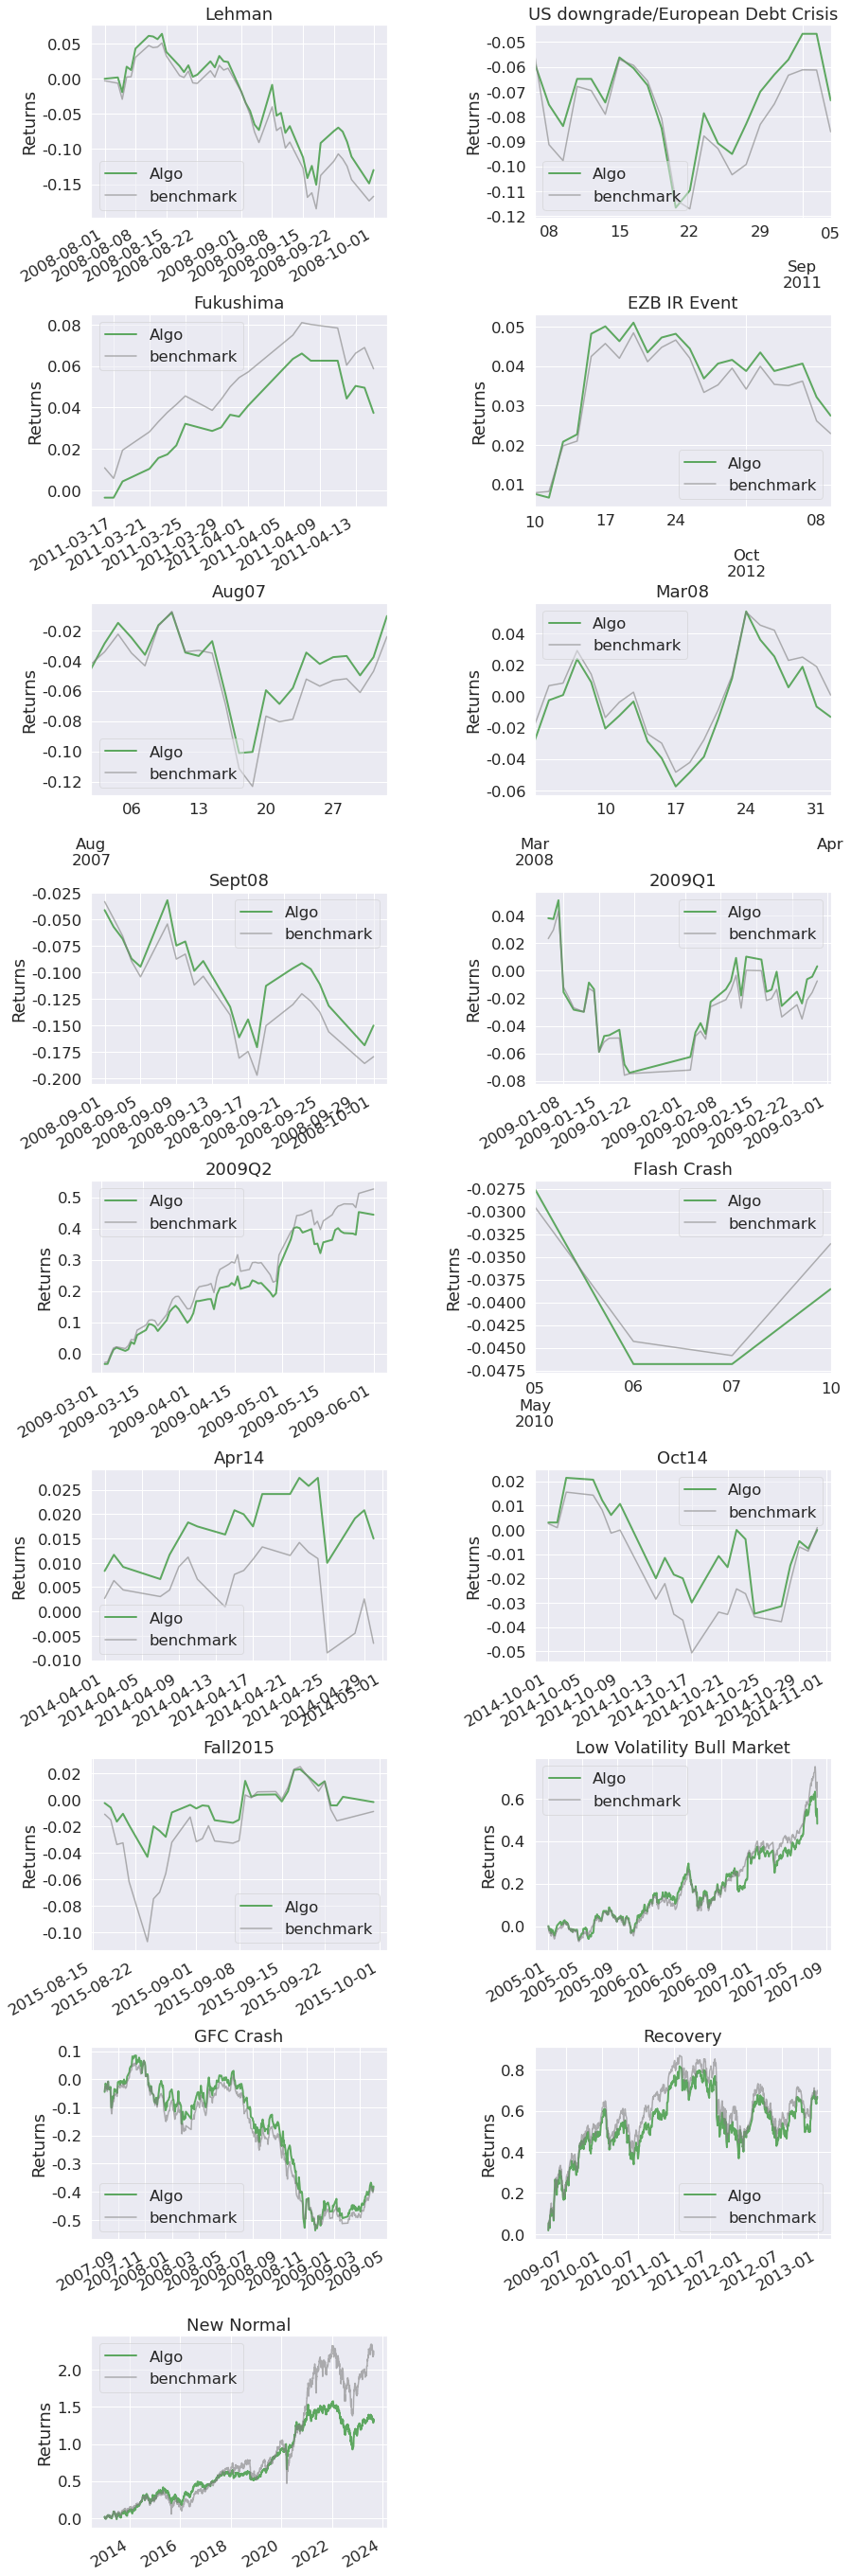

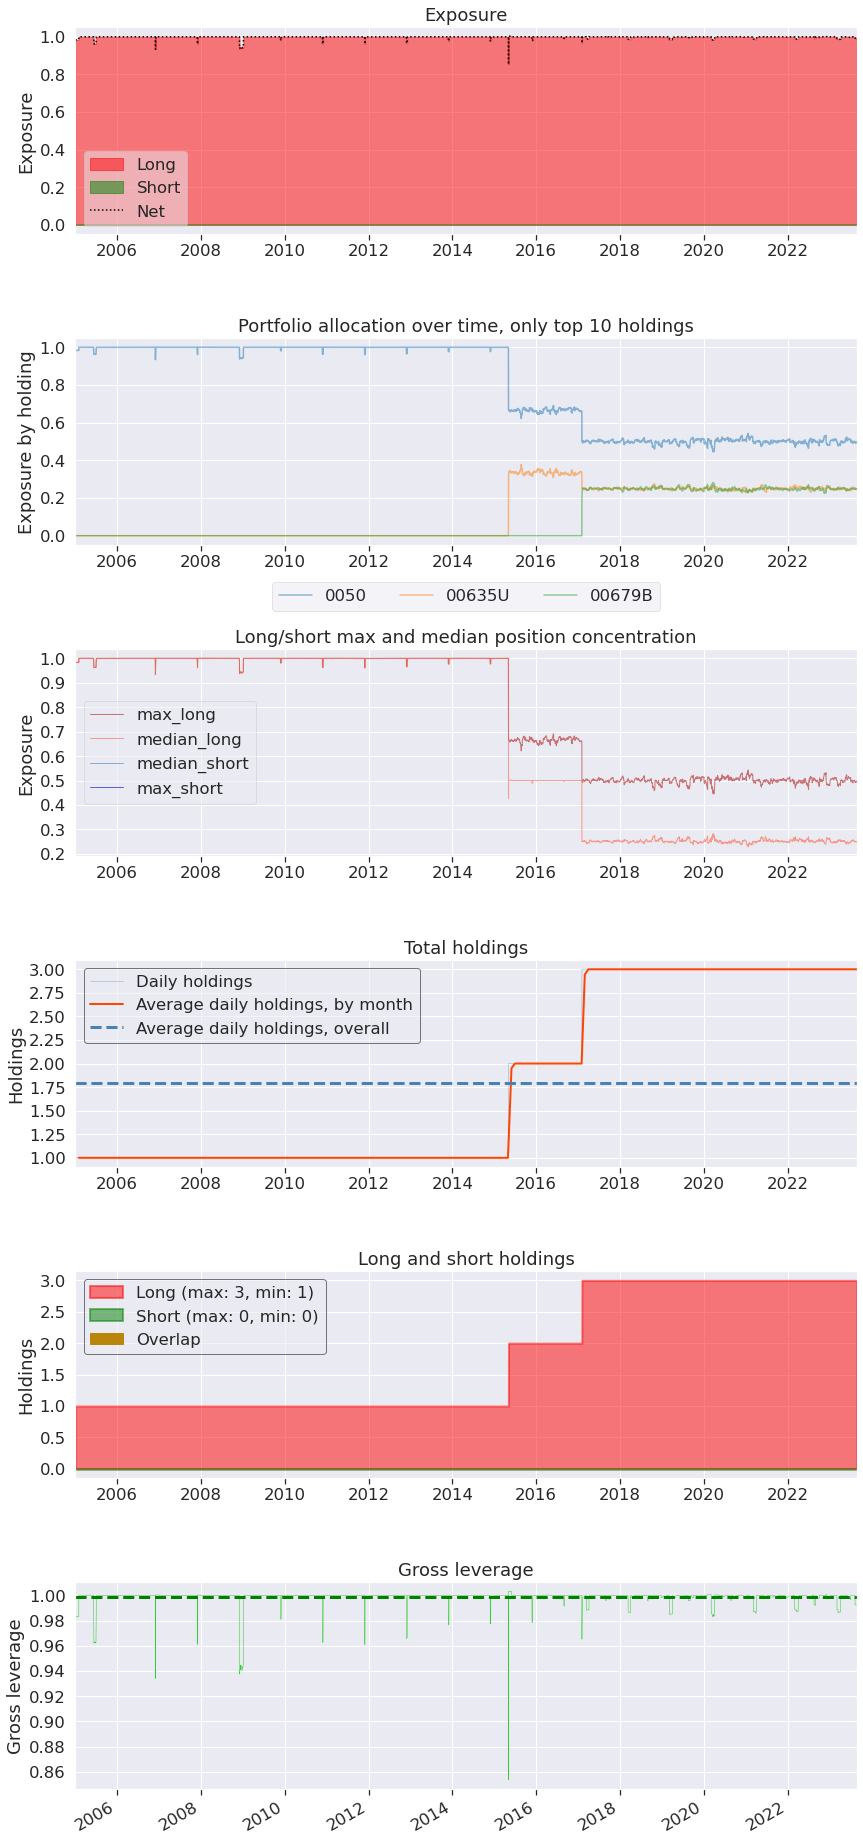

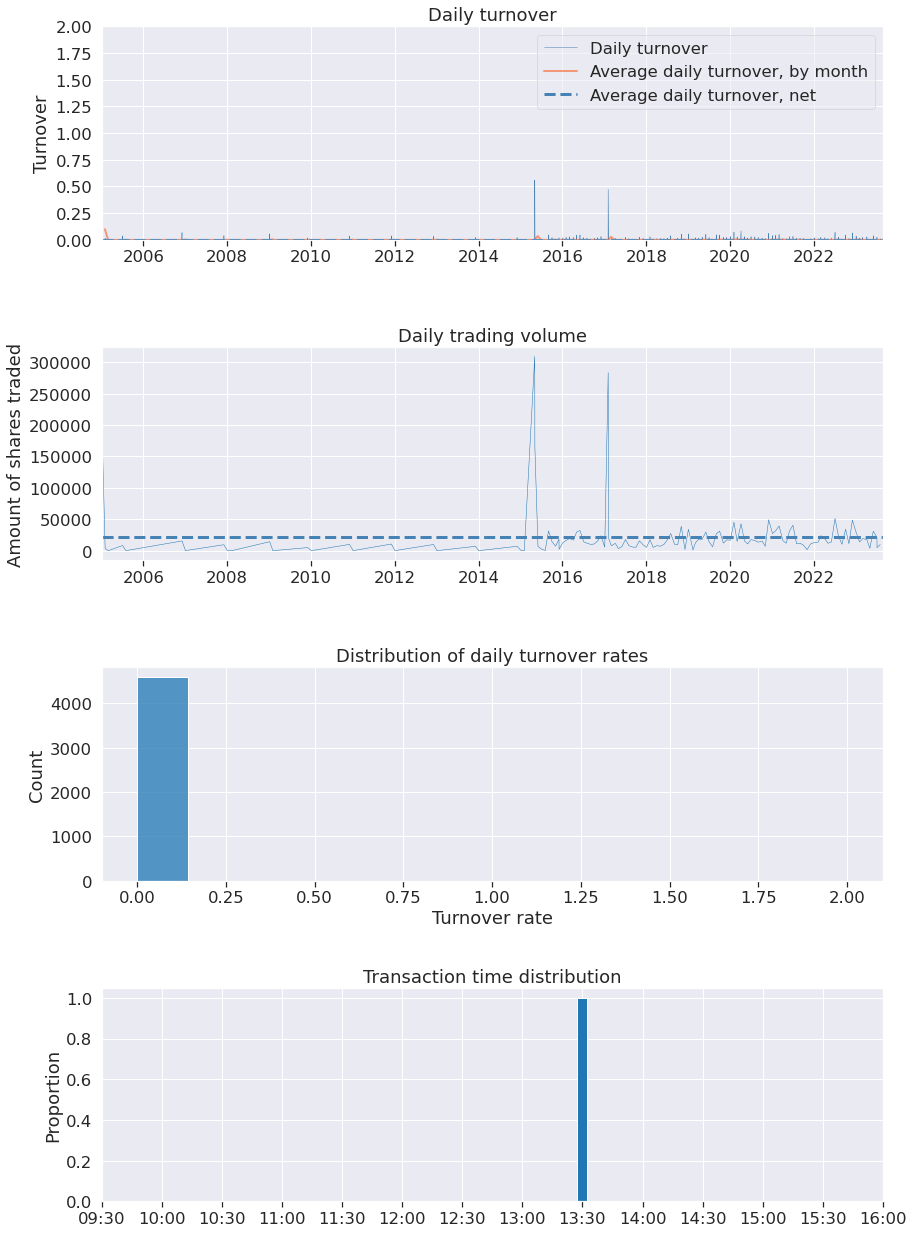

In [14]:
pf.tears.create_full_tear_sheet(returns=returns,
                                positions=positions,
                                transactions=transactions,
                                benchmark_rets=benchmark_rets,
                                live_start_date='20170202')